In [33]:
!pip install scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 13.0 MB/s eta 0:00:00a 0:00:01


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython import display
import scipy.stats as stats

# Implemented methods
methods = ['DynProg', 'ValIter']

# Some colours
LIGHT_RED    = '#FFC4CC'
LIGHT_GREEN  = '#95FD99'
BLACK        = '#000000'
WHITE        = '#FFFFFF'
LIGHT_PURPLE = '#E8D0FF'
LIGHT_ORANGE = '#FAE0C3'

In [ ]:

class Maze:

    # Actions
    STAY       = 0
    MOVE_LEFT  = 1
    MOVE_RIGHT = 2
    MOVE_UP    = 3
    MOVE_DOWN  = 4

    # Give names to actions
    actions_names = {
        STAY: "stay",
        MOVE_LEFT: "move left",
        MOVE_RIGHT: "move right",
        MOVE_UP: "move up",
        MOVE_DOWN: "move down"
    }

    # Reward values
    
    STEP_REWARD = 0         #TODO
    GOAL_REWARD = 1         #TODO
    IMPOSSIBLE_REWARD =  -100  #TODO
    MINOTAUR_REWARD = -1      #TODO


    def __init__(self, maze, allow_minotaur_stay):
        """ Constructor of the environment Maze.
        """
        self.maze                     = maze
        self.allow_minotaur_stay      = allow_minotaur_stay
        self.actions                  = self.__actions()
        self.states, self.map         = self.__states()
        self.n_actions                = len(self.actions)
        self.n_states                 = len(self.states)
        self.transition_probabilities = self.__transitions()
        self.rewards                  = self.__rewards()
        

    def __actions(self):
        actions = dict()
        actions[self.STAY]       = (0, 0)
        actions[self.MOVE_LEFT]  = (0,-1)
        actions[self.MOVE_RIGHT] = (0, 1)
        actions[self.MOVE_UP]    = (-1,0)
        actions[self.MOVE_DOWN]  = (1,0)
        return actions

    def __states(self):
        
        states = dict()
        map = dict()
        s = 0
        for i in range(self.maze.shape[0]):
            for j in range(self.maze.shape[1]):
                for k in range(self.maze.shape[0]):
                    for l in range(self.maze.shape[1]):
                        if self.maze[i,j] != 1:
                            states[s] = ((i,j), (k,l))
                            map[((i,j), (k,l))] = s
                            s += 1
        
        states[s] = 'Eaten'
        map['Eaten'] = s
        s += 1
        
        states[s] = 'Win'
        map['Win'] = s
        
        return states, map

    def __move(self, state, action):
        """ Makes a step in the maze, given a current position and an action. 
            If the action STAY or an inadmissible action is used, the player stays in place.
        
            :return list of tuples next_state: Possible states ((x,y), (x',y')) on the maze that the system can transition to.
        """
        if self.states[state] == 'Eaten' or self.states[state] == 'Win': # In these states, the game is over
            return [self.states[state]]
        
        else: 
            row_player = self.states[state][0][0] + self.actions[action][0] # Row of the player's next position 
            col_player = self.states[state][0][1] + self.actions[action][1] 
            # Is the player getting out of the limits of the maze or hitting a wall?
            impossible_action_player =  (row_player < 0 or row_player >= self.maze.shape[0] or 
                                col_player < 0 or col_player >= self.maze.shape[1] or 
                                (self.maze[row_player, col_player] == 1) # Check if the position is a wall
            )
            actions_minotaur = [[0, -1], [0, 1], [-1, 0], [1, 0]] # Possible moves for the Minotaur
           
            if self.allow_minotaur_stay:
                actions_minotaur.append([0, 0])
                
            rows_minotaur, cols_minotaur = [], []
            for i in range(len(actions_minotaur)):
                # Is the minotaur getting out of the limits of the maze?
                impossible_action_minotaur = (self.states[state][1][0] + actions_minotaur[i][0] == -1) or \
                                             (self.states[state][1][0] + actions_minotaur[i][0] == self.maze.shape[0]) or \
                                             (self.states[state][1][1] + actions_minotaur[i][1] == -1) or \
                                             (self.states[state][1][1] + actions_minotaur[i][1] == self.maze.shape[1])
            
                if not impossible_action_minotaur:
                    rows_minotaur.append(self.states[state][1][0] + actions_minotaur[i][0])
                    cols_minotaur.append(self.states[state][1][1] + actions_minotaur[i][1])  
            # Based on the impossiblity check return the next state.
            if impossible_action_player:
                # Stay in the current position if action is impossible
                states = []
                for i in range(len(rows_minotaur)):
                    
                    if (self.states[state][0][0], self.states[state][0][1]) == (rows_minotaur[i], cols_minotaur[i]):
                        states.append('Eaten')
                    
                    elif (self.states[state][0][0], self.states[state][0][1]) == (np.where(self.maze == 2)[0][0], np.where(self.maze == 2)[1][0]):
                        states.append('Win')
                
                    else:     
                     # The player moves to the new position, and the minotaur moves randomly
                        states.append(((self.states[state][0][0], self.states[state][0][1]), (rows_minotaur[i], cols_minotaur[i])))                

                return states
            else:  # The action is possible, the player moves to the new position
                states = []
                for i in range(len(rows_minotaur)):
                    if (row_player, col_player) == (rows_minotaur[i], cols_minotaur[i]):
                        # The player is caught by the minotaur
                        states.append('Eaten')
                    elif (row_player, col_player) == (np.where(self.maze == 2)[0][0], np.where(self.maze == 2)[1][0]):
                        # The player reaches the exit without being caught
                        states.append('Win')
                    else:
                        # The player moves to the new position, and the minotaur moves randomly
                        states.append(((row_player, col_player), (rows_minotaur[i], cols_minotaur[i])))

                return states

    def __transitions(self):
        """ Computes the transition probabilities for every state action pair.
            :return numpy.tensor transition probabilities: tensor of transition
            probabilities of dimension S*S*A
        """
        # Initialize the transition probailities tensor (S,S,A)
        dimensions = (self.n_states, self.n_states, self.n_actions)
        transition_probabilities = np.zeros(dimensions)

        # Compute the transition probabilities
        for s in range(self.n_states):
            for a in range(self.n_actions):
                current_state = self.states[s]

                # Handle terminal states: 'Eaten' and 'Win'
                if current_state == 'Eaten':
                    transition_probabilities[self.map['Eaten'], s, a] = 1.0
                    continue
                elif current_state == 'Win':
                    transition_probabilities[self.map['Win'], s, a] = 1.0
                    continue

                # Get next possible states for the given action
                next_states = self.__move(s, a)

                # Distribute probability equally among all valid next states
                prob = 1.0 / len(next_states)

                for next_state in next_states:
                    transition_probabilities[self.map[next_state], s, a] = prob

        return transition_probabilities

    def __rewards(self):
        
        """ Computes the rewards for every state action pair """

        rewards = np.zeros((self.n_states, self.n_actions))
        
        for s in range(self.n_states):
            for a in range(self.n_actions):
                
                if self.states[s] == 'Eaten': # The player has been eaten
                    rewards[s, a] = self.MINOTAUR_REWARD
                
                elif self.states[s] == 'Win': # The player has won
                    rewards[s, a] = self.GOAL_REWARD
                
                else:                
                    next_states = self.__move(s,a)
                    next_s = next_states[0] # The reward does not depend on the next position of the minotaur, we just consider the first one
                    #print("next_s is: ", next_s)
                    if self.states[s][0] == next_s[0] and a != self.STAY: # The player hits a wall
                        rewards[s, a] = self.IMPOSSIBLE_REWARD
                    
                    else: # Regular move
                        rewards[s, a] = self.STEP_REWARD
        return rewards
    
    def simulate(self, start, policy, method):
        if method not in methods:
            error = 'ERROR: the argument method must be in {}'.format(methods);
            raise NameError(error)

        path = list()
        if method == 'DynProg':  
            horizon = policy.shape[1] # Deduce the horizon from the policy shape
            t = 0  # Initialize current time
            s = self.map[start] # Initialize current state 
            path.append(start) # Add the starting position in the maze to the path
            while t < horizon - 1:
                #next_s = self.__move(s, policy[s, t]) # Move to next state given the policy and the current state
                #path.append(self.states[next_s])
                #t +=1
                #s = next_s
                
                a = policy[s, t] # Move to next state given the policy and the current state
                next_states = self.__move(s, a) 
                next_s = next_states[0]
                path.append(next_s) # Add the next state to the path
                t +=1 # Update time and state for next iteration
                s = self.map[next_s]
                
                
        if method == 'ValIter':
            t = 0 # Initialize current state, next state and time
            s = self.map[start]
            # Add the starting position in the maze to the path
            path.append(start)
            while True: 
                if np.random.rand() < 1/30:
                    path.append('Poisoned') 
                    break

                a = policy[s]
                next_states = self.__move(s, a)  # Move to next state given the policy and the current state
                next_s = next_states[0] #self.states[next_s]
                path.append(next_s)
                if next_s == 'Win' or next_s == 'Eaten':
                    break
                # Update time for next iteration
                s = self.map[next_s]
                t +=1
                
            horizon = t   
        return [path, horizon]

    
    
    def survival_rate_horizon(self, start, policy):
        states = set()
        num_states = dict()
        prob_states = dict()

        states.add(start)
        num_states[start] = 1
        prob_states[start] = 1
        
        horizon = policy.shape[1]

        t = 0
        while t < horizon:
            next_states = set()
            next_num = dict()
            next_prob = dict()
            next_total = 0

            #print("States at {}: unique {}, total {}".format(t, len(states), total_num_states))
            for s in states:
                
                s_count = num_states[s]
                s_prob = prob_states[s]
                s = self.map[s]
                action = policy[s, t]
                new_states = self.__move(s, action)

                each_ns_prob = s_prob / len(new_states)

                for ns in new_states:
                    next_num[ns] = next_num.get(ns, 0) + s_count
                    next_prob[ns] = next_prob.get(ns, 0) + each_ns_prob

                    next_states.add(ns)
                    next_total += s_count

            # nothing moving, break
            if next_states == states:
                break

            states = next_states
            num_states = next_num
            prob_states = next_prob
            t += 1

        won = 0
        dead = 0
        for state, prob in prob_states.items():
            if state == 'Eaten':
                dead += prob
            elif state == 'Win':
                won += prob

        print("T = {}, win {:06.2%}, dead {:06.2%}".format(horizon-1, won, dead))

        return won

In [3]:

def show(self):
    print('The states are :')
    print(self.states)
    print('The actions are:')
    print(self.actions)
    print('The mapping of the states:')
    print(self.map)
    print('The rewards:')
    print(self.rewards)

In [114]:
def dynamic_programming(env, horizon):
    """ Solves the shortest path problem using dynamic programming
        :input Maze env           : The maze environment in which we seek to
                                    find the shortest path.
        :input int horizon        : The time T up to which we solve the problem.
        :return numpy.array V     : Optimal values for every state at every
                                    time, dimension S*T
        :return numpy.array policy: Optimal time-varying policy at every state,
                                    dimension S*T
    """

    # The dynamic prgramming requires the knowledge of :
    # - Transition probabilities
    # - Rewards
    # - State space
    # - Action space
    # - The finite horizon
    p         = env.transition_probabilities
    r         = env.rewards
    n_states  = env.n_states
    n_actions = env.n_actions
    T         = horizon

    # The variables involved in the dynamic programming backwards recursions
    V      = np.zeros((n_states, T+1))
    policy = np.zeros((n_states, T+1))
    Q      = np.zeros((n_states, n_actions))


    # Initialization

    Q            = np.copy(r)
    V[:, T]      = np.max(Q, 1)
    policy[:, T] = np.argmax(Q, 1)

    # The dynamic programming bakwards recursion
    for t in range(T-1, -1, -1):
        # Update the value function acccording to the bellman equation
        for s in range(n_states):
            for a in range(n_actions):
                # Update of the temporary Q values
                #print("rewards: ", Q[s, a])
                #print("Transition probabilities:", p)
                Q[s, a] = r[s, a] + np.dot(p[:, s, a], V[:, t+1])
        # Update by taking the maximum Q value w.r.t the action a
        V[:, t] = np.max(Q, 1)

        # The optimal action is the one that maximizes the Q function
        policy[:, t] = np.argmax(Q, 1)

    return V, policy


In [ ]:

def value_iteration(env, gamma, epsilon):
    """ Solves the shortest path problem using value iteration
        :input Maze env           : The maze environment in which we seek to
                                    find the shortest path.
        :input float gamma        : The discount factor.
        :input float epsilon      : accuracy of the value iteration procedure.
        :return numpy.array V     : Optimal values for every state at every
                                    time, dimension S*T
        :return numpy.array policy: Optimal time-varying policy at every state,
                                    dimension S*T
    """
    # The value itearation algorithm requires the knowledge of :
    # - Transition probabilities
    # - Rewards
    # - State space
    # - Action space
    p         = env.transition_probabilities
    r         = env.rewards
    n_states  = env.n_states
    n_actions = env.n_actions

    # Required variables and temporary ones for the VI to run
    V   = np.zeros(n_states)
    Q   = np.zeros((n_states, n_actions))
    BV  = np.zeros(n_states)
    # Iteration counter
    n   = 0
    # Tolerance error
    tol = (1 - gamma) * epsilon/gamma

    # Initialization of the VI
    for s in range(n_states):
        for a in range(n_actions):
            Q[s, a] = r[s, a] + gamma * np.dot(p[:, s, a], V)
    BV = np.max(Q, 1)

    # Iterate until convergence
    while np.linalg.norm(V - BV) >= tol and n < 200:
        # Increment by one the numbers of iteration
        n += 1
        # Update the value function
        V = np.copy(BV)
        # Compute the new BV
        for s in range(n_states):
            for a in range(n_actions):
                Q[s, a] = r[s, a] + gamma * np.dot(p[:, s, a], V)
        BV = np.max(Q, 1)
        # Show error
        #print(np.linalg.norm(V - BV))

    # Compute policy
    policy = np.argmax(Q,1)
    
    # Return the obtained policy
    return V, policy

In [140]:
def survival_rates_dynprog(maze, T_range, minotaur_stay = False):
    """
    possible kwargs are minotaur_stay, avoid_minotaur, and min_path
    """
    env = Maze(maze, minotaur_stay)

    sr = []
    policies = {}

    start = ((0,0), (6,5))

    for T in T_range:
        V, policy = dynamic_programming(env, T)
        rate = env.survival_rate_horizon(start, policy)
        sr.append(rate)
        policies[T] = policy 
    return sr, policies

In [161]:
def survival_rate_valiter(maze, mean_lifetime, min_steps, minotaur_stay = False):
   
        env = Maze(maze, allow_minotaur_stay=minotaur_stay)

        # Discount Factor
        gamma = 1 - (1/mean_lifetime)
        # Accuracy treshold 
        epsilon = 0.0001
        V, policy = value_iteration(env, gamma, epsilon)

        start = ((0,0), (6,5))

        rate, avg_path_len = env.survival_rate_simulated(start, policy, "ValIter")
        
        won = 0
        total_path_len = 0
        simulation_num = 10000
        for i in range(simulation_num):
            path = env.simulate(start, policy, "ValIter")
            last_state = path[0][-1]
            #print("mapped: ", self.map[last_state])
            if last_state == 'Win':
                won += 1
            total_path_len += len(path[0])
        
        rate = won/simulation_num
        avg_path_len = total_path_len/simulation_num

        print("Survived {:%}, compared to {:%} baseline".format(rate, 1-stats.geom.cdf(min_steps, 1/mean_lifetime)))
        print("Avg. lifetime ", avg_path_len-1)

        return rate

In [144]:
# Description of the maze as a numpy array
maze = np.array([
    [0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0, 1, 1, 1],
    [0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 0],
    [0, 0, 0, 0, 1, 2, 0, 0]])
# With the convention 0 = empty cell, 1 = obstacle, 2 = exit of the Maze

env = Maze(maze, False) # Create an environment maze
horizon = 15     # TODO: Finite horizon

# Solve the MDP problem with dynamic programming
V, policy = dynamic_programming(env, horizon)  
# Simulate the shortest path starting from position A
method = 'DynProg'
start  = ((0,0), (6,5))
path = env.simulate(start, policy, method)[0]
print(path)


[((0, 0), (6, 5)), ((0, 1), (6, 4)), ((1, 1), (6, 3)), ((2, 1), (6, 2)), ((3, 1), (6, 1)), ((4, 1), (6, 0)), ((4, 2), (6, 1)), ((4, 3), (6, 0)), ((4, 4), (6, 1)), ((4, 5), (6, 0)), ((4, 6), (6, 1)), ((4, 7), (6, 0)), ((5, 7), (6, 1)), ((6, 7), (6, 0)), ((6, 6), (6, 1)), 'Win']


In [141]:
exit = (6, 5)
T_range = np.array(range(13, 31))
print("Minotaur always moves:")
move_rates, policy_move = survival_rates_dynprog(maze, T_range, minotaur_stay = False)
print("Minotaur can stay: ")
try_rates, policy_stay = survival_rates_dynprog(maze, T_range, minotaur_stay = True)


Minotaur always moves:
T = 13, win 00.00%, dead 00.12%
T = 14, win 00.00%, dead 00.28%
T = 15, win 100.00%, dead 00.00%
T = 16, win 100.00%, dead 00.00%
T = 17, win 100.00%, dead 00.00%
T = 18, win 100.00%, dead 00.00%
T = 19, win 100.00%, dead 00.00%
T = 20, win 100.00%, dead 00.00%
T = 21, win 100.00%, dead 00.00%
T = 22, win 100.00%, dead 00.00%
T = 23, win 100.00%, dead 00.00%
T = 24, win 100.00%, dead 00.00%
T = 25, win 100.00%, dead 00.00%
T = 26, win 100.00%, dead 00.00%
T = 27, win 99.32%, dead 00.68%
T = 28, win 99.32%, dead 00.68%
T = 29, win 99.16%, dead 00.84%
T = 30, win 99.16%, dead 00.84%
Minotaur can stay: 
T = 13, win 00.00%, dead 00.00%
T = 14, win 00.00%, dead 00.00%
T = 15, win 71.18%, dead 28.82%
T = 16, win 71.18%, dead 28.82%
T = 17, win 71.18%, dead 28.82%
T = 18, win 75.33%, dead 24.67%
T = 19, win 77.17%, dead 22.83%
T = 20, win 78.65%, dead 21.35%
T = 21, win 80.62%, dead 19.38%
T = 22, win 82.68%, dead 17.32%
T = 23, win 83.42%, dead 16.58%
T = 24, win 83.68

In [142]:
def print_policy(policy, env, T):
    """
    Prints the optimal policy for each state at each time step.
    
    :param policy: The optimal policy array (S*T).
    :param env: The maze environment (for state interpretation).
    :param T: The time horizon for which the policy was computed.
    """
    print(f"Optimal policy for T={T}:")
    for t in range(T):
        print(f"Time step {t}:")
        for s in range(env.n_states):
            action = int(policy[s, t])
            if action in env.actions_names:
                state_description = env.states[s]
                print(f"  State {s} ({state_description}): {env.actions_names[action]}")
        print("\n")

# Example usage for T=30
T_to_inspect = 15
print_policy(policy_move[T_to_inspect], env, T_to_inspect)

Optimal policy for T=15:
Time step 0:
  State 0 (((0, 0), (0, 0))): move down
  State 1 (((0, 0), (0, 1))): move right
  State 2 (((0, 0), (0, 2))): move down
  State 3 (((0, 0), (0, 3))): move right
  State 4 (((0, 0), (0, 4))): move right
  State 5 (((0, 0), (0, 5))): move right
  State 6 (((0, 0), (0, 6))): move right
  State 7 (((0, 0), (0, 7))): move right
  State 8 (((0, 0), (1, 0))): move right
  State 9 (((0, 0), (1, 1))): move down
  State 10 (((0, 0), (1, 2))): move right
  State 11 (((0, 0), (1, 3))): move down
  State 12 (((0, 0), (1, 4))): move right
  State 13 (((0, 0), (1, 5))): move right
  State 14 (((0, 0), (1, 6))): move right
  State 15 (((0, 0), (1, 7))): move right
  State 16 (((0, 0), (2, 0))): move right
  State 17 (((0, 0), (2, 1))): move right
  State 18 (((0, 0), (2, 2))): move down
  State 19 (((0, 0), (2, 3))): move right
  State 20 (((0, 0), (2, 4))): move down
  State 21 (((0, 0), (2, 5))): move right
  State 22 (((0, 0), (2, 6))): move right
  State 23 (

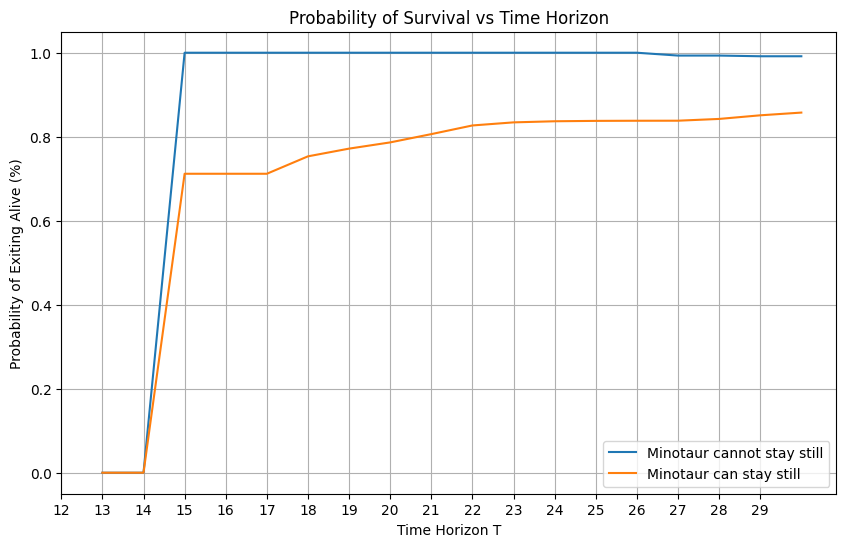

In [138]:
# Plot the probabilities
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(move_rates) + 1), move_rates, label='Minotaur cannot stay still')
plt.plot(range(1, len(try_rates) + 1), try_rates, label='Minotaur can stay still')
tick_positions = range(len(move_rates))  # Positions from 0 to len(move_rates) - 1
tick_labels = range(12, 12 + len(move_rates))  # Labels starting from 15

plt.xticks(tick_positions, tick_labels)
plt.xlabel('Time Horizon T')
plt.ylabel('Probability of Exiting Alive (%)')  # Updated label to indicate percentage
plt.title('Probability of Survival vs Time Horizon')
plt.legend()
plt.grid(True)
plt.show()

In [160]:
# Can not stay: 
survival_rate_valiter(maze, mean_lifetime = 30, min_steps = 15, minotaur_stay = False)


Survived 58.310000%, compared to 60.138300% baseline
Avg. lifetime  12.5829


0.5831

In [162]:
# can stay: 
survival_rate_valiter(maze, mean_lifetime = 30, min_steps = 15, minotaur_stay = True)
  

Survived 58.450000%, compared to 60.138300% baseline
Avg. lifetime  12.5866


0.5845

In [167]:
# Description of the maze as a numpy array
maze = np.array([
    [0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0, 1, 1, 1],
    [0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 0],
    [0, 0, 0, 0, 1, 2, 0, 0]])
# With the convention 0 = empty cell, 1 = obstacle, 2 = exit of the Maze

env = Maze(maze, True) # Create an environment maze

In [168]:
method = 'ValIter'
start  = ((0,0), (6,5))

paths = list()
win_score = 0
t_list = list()

n_iters = 10000

# Discount Factor
gamma = 1 - (1/30)
# Accuracy treshold 
epsilon = 0.0001
V, policy = value_iteration(env, gamma, epsilon)

for i in range(n_iters):
    path = env.simulate(start, policy, method)
    if path[0][-1] == 'Win': 
        win_score += 1
    
probability_of_exit = win_score/n_iters
probability_of_exit

0.5803

In [110]:
def animate_solution(maze, path):

    # Map a color to each cell in the maze
    col_map = {0: WHITE, 1: BLACK, 2: LIGHT_GREEN, -1: LIGHT_RED, -2: LIGHT_PURPLE}
    
    rows, cols = maze.shape # Size of the maze
    fig = plt.figure(1, figsize=(cols, rows)) # Create figure of the size of the maze

    # Remove the axis ticks and add title
    ax = plt.gca()
    ax.set_title('Policy simulation')
    ax.set_xticks([])
    ax.set_yticks([])

    # Give a color to each cell
    colored_maze = [[col_map[maze[j, i]] for i in range(cols)] for j in range(rows)]

    # Create a table to color
    grid = plt.table(
        cellText = None, 
        cellColours = colored_maze, 
        cellLoc = 'center', 
        loc = (0,0), 
        edges = 'closed'
    )
    
    # Modify the height and width of the cells in the table
    tc = grid.properties()['children']
    for cell in tc:
        cell.set_height(1.0/rows)
        cell.set_width(1.0/cols)
    for i in range(0, len(path)):
        if i < len(path): 
            grid.get_celld()[(path[i][0])].get_text().set_text('Player')
            grid.get_celld()[(path[i][1])].get_text().set_text('Minotaur')
        if path[i-1] != 'Eaten' and path[i-1] != 'Win':
            grid.get_celld()[(path[i-1][0])].set_facecolor(col_map[maze[path[i-1][0]]])
            grid.get_celld()[(path[i-1][1])].set_facecolor(col_map[maze[path[i-1][1]]])
            if i < len(path)-1:
                grid.get_celld()[(path[i-1][0])].get_text().set_text('')
                grid.get_celld()[(path[i-1][1])].get_text().set_text('')
        if path[i] != 'Eaten' and path[i] != 'Win':
            grid.get_celld()[(path[i][0])].set_facecolor(col_map[-2]) # Position of the player
            grid.get_celld()[(path[i][1])].set_facecolor(col_map[-1]) # Position of the minotaur
        display.display(fig)
        time.sleep(0.1)
        display.clear_output(wait = True)
        if i < len(path)-1:
            grid.get_celld()[(path[i][0])].get_text().set_text('')
            grid.get_celld()[(path[i][1])].get_text().set_text('')


In [100]:
# Description of the maze as a numpy array
maze = np.array([
    [0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0, 1, 1, 1],
    [0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 0],
    [0, 0, 0, 0, 1, 2, 0, 0]])
# With the convention 0 = empty cell, 1 = obstacle, 2 = exit of the Maze
env1 = Maze(maze, False)
env2 = Maze(maze, True) # Create an environment maze
horizon = 16     # TODO: Finite horizon

# Solve the MDP problem with dynamic programming
V, policy = dynamic_programming(env1, horizon)  
V2, policy2 = dynamic_programming(env2, horizon)  
# Simulate the shortest path starting from position A
method = 'DynProg'
start  = ((0,0), (6,5))
can_stay = env.simulate(start, policy, method)[0]
cant_stay = env.simulate(start, policy2, method)[0]

KeyError: 'W'

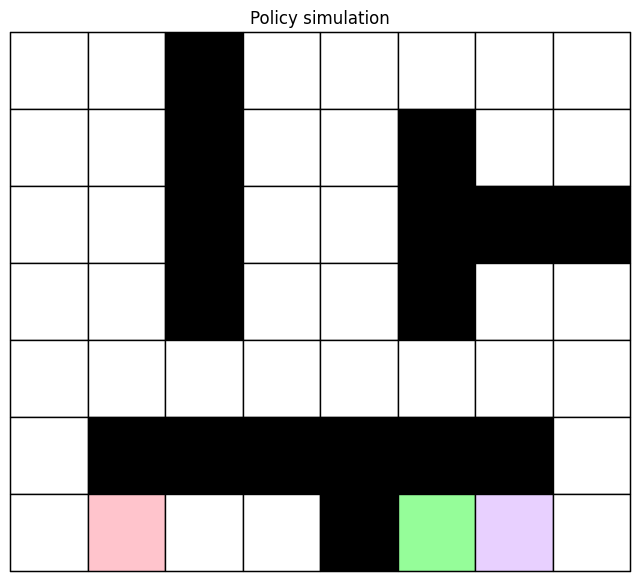

In [169]:

animate_solution(maze, can_stay)

If the minotaur is not allowed to stand still, it is never possible that the player is caught by the minotaur. This is because the minotaur will always be in an even location at an even value of t and in an odd location at each odd value of t. (where t starts at 0 (=even) and an even location is defined as the sum of the x-value and y-value is even e.g. (4,6) = 10 = even).

The player starts at an even location and will just wait one step, then take one step at each timestep and thus always avoid the minotaur, since the player will be in an even location when the minotaur is in an odd location and vice versa.